# Asheville Demos Scratchbook

In [346]:
import requests
import pandas as pd
import geopandas as gp
import keplergl
from matplotlib import pyplot as plt

load_dotenv()

import seaborn as sns
from dotenv import load_dotenv
import os

# HUD Section 8 Vouchers by Tract

From https://hudgis-hud.opendata.arcgis.com/datasets/housing-choice-vouchers-by-tract/

In [407]:
hcv = pd.read_csv('~/Desktop/hcv_tracts.csv')
hcv = hcv.rename(columns={'HCV_PUBLIC':'hcv_section_8_total_count'})
hcv['GEOID'] = hcv['GEOID'].astype(str)
hcv.head()

,OBJECTID,GEOID,STATE,COUNTY,TRACT,hcv_section_8_total_count,HCV_PUBLIC_PCT,Shape__Area,Shape__Length
0,1,4013104502,NaN,NaN,NaN,35,3.87,1.938618e+06,6427.748464
1,3,4013107900,NaN,NaN,NaN,48,8.16,1.122223e+07,16799.699001
2,7,4019004071,NaN,NaN,NaN,55,2.77,1.868483e+06,6302.935748
3,12,4013420208,NaN,NaN,NaN,12,2.05,3.728531e+06,7731.833224
4,16,4013082010,NaN,NaN,NaN,16,4.27,1.870826e+06,5812.849221


# Census Tracts

In [484]:
URL = 'https://api.census.gov/data/2018/acs/acs5'
QUERY = '?get=NAME,B02001_001E,B02001_002E,B02001_003E,B19013_001E,B25071_001E&for=tract:*&in=state:37+county:021'
API_KEY = '&key=' + os.getenv('CENSUS_API_KEY')

In [485]:
vals = requests.get(URL+QUERY+API_KEY).json()

In [486]:
tract_id = [v[6] + v[7] + v[8] for v in vals]
pop = [v[1] for v in vals]
white = [v[2] for v in vals]
black = [v[3] for v in vals]
hh_income = [v[4] for v in vals]
rent_burden = [v[5] for v in vals]

In [487]:
df = pd.DataFrame({'tract_id':tract_id,'pop':pop,'white':white,'black':black,'hh_income':hh_income,'rent_burden':rent_burden}).drop(0).set_index('tract_id')

In [488]:
for c in df.columns:
    df[c] = df[c].astype(float)

In [489]:
df['pct_black'] = df['black']/df['pop']
df['pct_white'] = df['white']/df['pop']
df['pct_overall_black_population'] = df['black']/df.sum()['black']
df = df.reset_index()

In [490]:
df = df.merge(hcv[['GEOID','hcv_section_8_total_count']],how='left',left_on='tract_id',right_on='GEOID').drop(columns='GEOID')
df['hcv_section_8_total_count'] = df['hcv_section_8_total_count'].mask(df['hcv_section_8_total_count'].isna(),0)

In [491]:
pct_cols = [c for c in df.columns if 'pct' in c]

for c in pct_cols:
    df[c] = (df[c]*100).round(2)

In [492]:
numeric = [n for n in df.select_dtypes(include=['int64','float64']).columns]
df[numeric] = df[numeric].mask(df[numeric] < 0,-1)

In [493]:
df.sort_values(by='rent_burden',ascending=False).head()

,tract_id,pop,white,black,hh_income,rent_burden,pct_black,pct_white,pct_overall_black_population,hcv_section_8_total_count
55,37021003202,4085.0,3893.0,123.0,69483.0,51.0,3.01,95.30,0.76,0.0
43,37021002604,5542.0,5401.0,27.0,52569.0,51.0,0.49,97.46,0.17,15.0
39,37021002504,4439.0,4224.0,0.0,43880.0,48.9,0.00,95.16,0.00,42.0
29,37021003205,1177.0,1142.0,0.0,40441.0,48.2,0.00,97.03,0.00,0.0
42,37021002603,3914.0,3683.0,55.0,37568.0,44.1,1.41,94.10,0.34,14.0


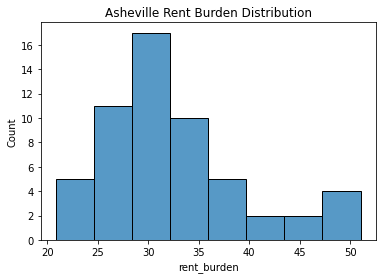

In [494]:
fig = sns.histplot(df.rent_burden)
fig.set_title('Asheville Rent Burden Distribution')
plt.show()

In [495]:
shape_path = './nc shapefiles/tl_2018_37_tract' 
gpdf = gp.read_file(shape_path)
gpdf = gpdf.loc[gpdf.COUNTYFP == '021']

In [496]:
buncombe = gpdf[['GEOID','geometry']].merge(df,left_on='GEOID',right_on='tract_id',how='inner').drop(columns='GEOID')

# Census Block Groups

In [497]:
URL = 'https://api.census.gov/data/2018/acs/acs5'
GEO = '&for=block group:*&in=state:37&in=county:021&in=tract:*'
VAR = '?get=NAME,B02001_001E,B02001_002E,B02001_003E,B19013_001E,B25071_001E'
API_KEY = '&key=' + os.getenv('CENSUS_API_KEY')

In [498]:
vals = requests.get(URL+VAR+GEO+API_KEY).json()

In [499]:
block_group_id = [v[6] + v[7] + v[8] + v[9] for v in vals]
pop = [v[1] for v in vals]
white = [v[2] for v in vals]
black = [v[3] for v in vals]
hh_income = [v[4] for v in vals]
rent_burden = [v[5] for v in vals]

In [500]:
df = pd.DataFrame({'block_group_id':block_group_id,'pop':pop,'white':white,'black':black,'hh_income':hh_income,'rent_burden':rent_burden}).drop(0).set_index('block_group_id')

In [501]:
for c in df.columns:
    df[c] = df[c].astype(float)

In [502]:
df['pct_black'] = df['black']/df['pop']
df['pct_white'] = df['white']/df['pop']

In [503]:
numeric = [n for n in df.select_dtypes(include=['int64','float64']).columns]
df[numeric] = df[numeric].mask(df[numeric] < 0,-1)

In [504]:
df.head()

,pop,white,black,hh_income,rent_burden,pct_black,pct_white
block_group_id,,,,,,,
370210001001,1499.0,1120.0,233.0,23646.0,28.0,0.155437,0.747165
370210003001,1426.0,933.0,426.0,32670.0,40.0,0.298738,0.654278
370210003002,789.0,628.0,126.0,64750.0,25.4,0.159696,0.795944
370210008002,1425.0,1196.0,176.0,84342.0,21.2,0.123509,0.839298
370210008003,1158.0,1125.0,25.0,54632.0,30.7,0.021589,0.971503


In [505]:
df['pct_overall_black_population'] = df['black']/df.sum()['black']

In [506]:
pct_cols = [c for c in df.columns if 'pct' in c]

for c in pct_cols:
    df[c] = (df[c]*100).round(2)

In [507]:
df = df.reset_index()
df.sort_values(by='pct_black',ascending=False).head()

,block_group_id,pop,white,black,hh_income,rent_burden,pct_black,pct_white,pct_overall_black_population
131,370210020004,1944.0,646.0,1155.0,45066.0,27.4,59.41,33.23,7.18
8,370210009001,606.0,262.0,344.0,-1.0,25.4,56.77,43.23,2.14
6,370210009003,1653.0,751.0,889.0,20066.0,29.9,53.78,45.43,5.52
37,370210020003,594.0,288.0,303.0,33542.0,49.2,51.01,48.48,1.88
7,370210009002,790.0,440.0,348.0,-1.0,25.6,44.05,55.70,2.16


In [508]:
shape_path = './nc shapefiles/tl_2018_37_bg' 
gpdf = gp.read_file(shape_path)
gpdf = gpdf.loc[gpdf.COUNTYFP == '021']

In [509]:
buncombebg = gpdf[['GEOID','geometry']].merge(df,left_on='GEOID',right_on='block_group_id',how='inner').drop(columns='GEOID')

In [510]:
buncombebg.head()

,geometry,block_group_id,pop,white,black,hh_income,rent_burden,pct_black,pct_white,pct_overall_black_population
0,"POLYGON ((-82.58716 35.56669, -82.58690 35.566...",370210010002,1800.0,1255.0,468.0,43542.0,27.5,26.00,69.72,2.91
1,"POLYGON ((-82.57600 35.57008, -82.57597 35.570...",370210010003,804.0,732.0,10.0,51467.0,30.8,1.24,91.04,0.06
2,"POLYGON ((-82.59467 35.58288, -82.59452 35.583...",370210011001,1243.0,857.0,204.0,55588.0,24.3,16.41,68.95,1.27
3,"POLYGON ((-82.60947 35.58552, -82.60927 35.585...",370210012001,1027.0,980.0,47.0,57917.0,24.6,4.58,95.42,0.29
4,"POLYGON ((-82.61422 35.57534, -82.61370 35.575...",370210012002,722.0,617.0,27.0,70750.0,51.0,3.74,85.46,0.17


In [511]:
m = keplergl.KeplerGl()
m.add_data(data=buncombe,name='ACS - 5 Year 2018 - Census Tracts')
m.add_data(data=buncombebg,name='ACS - 5 Year 2018 - Block Groups')

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


In [524]:
config = {'version': 'v1',
 'config': {'visState': {'filters': [],
   'layers': [{'id': '6m3cfn4',
     'type': 'geojson',
     'config': {'dataId': 'ACS - 5 Year 2018 - Census Tracts',
      'label': 'ACS - 5 Year 2018 - Census Tracts',
      'color': [18, 147, 154],
      'columns': {'geojson': 'geometry'},
      'isVisible': True,
      'visConfig': {'opacity': 0.33,
       'strokeOpacity': 0.8,
       'thickness': 0.5,
       'strokeColor': [221, 178, 124],
       'colorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#FFC300',
         '#F1920E',
         '#E3611C',
         '#C70039',
         '#900C3F',
         '#5A1846'],
        'reversed': True},
       'strokeColorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'radius': 10,
       'sizeRange': [0, 10],
       'radiusRange': [0, 50],
       'heightRange': [0, 500],
       'elevationScale': 5,
       'stroked': True,
       'filled': True,
       'enable3d': False,
       'wireframe': False},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [255, 255, 255],
        'size': 18,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': {'name': 'rent_burden', 'type': 'real'},
      'colorScale': 'quantile',
      'sizeField': None,
      'sizeScale': 'linear',
      'strokeColorField': None,
      'strokeColorScale': 'quantile',
      'heightField': None,
      'heightScale': 'linear',
      'radiusField': None,
      'radiusScale': 'linear'}},
    {'id': 'nn1supi',
     'type': 'geojson',
     'config': {'dataId': 'ACS - 5 Year 2018 - Block Groups',
      'label': 'ACS - 5 Year 2018 - Block Groups',
      'color': [136, 87, 44],
      'columns': {'geojson': 'geometry'},
      'isVisible': True,
      'visConfig': {'opacity': 0.4,
       'strokeOpacity': 0.8,
       'thickness': 0.5,
       'strokeColor': [255, 153, 31],
       'colorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#FFC300',
         '#F1920E',
         '#E3611C',
         '#C70039',
         '#900C3F',
         '#5A1846'],
        'reversed': True},
       'strokeColorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'radius': 10,
       'sizeRange': [0, 10],
       'radiusRange': [0, 50],
       'heightRange': [0, 500],
       'elevationScale': 5,
       'stroked': True,
       'filled': True,
       'enable3d': False,
       'wireframe': False},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [255, 255, 255],
        'size': 18,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': {'name': 'rent_burden', 'type': 'real'},
      'colorScale': 'quantile',
      'sizeField': None,
      'sizeScale': 'linear',
      'strokeColorField': None,
      'strokeColorScale': 'quantile',
      'heightField': None,
      'heightScale': 'linear',
      'radiusField': None,
      'radiusScale': 'linear'}}],
   'interactionConfig': {'tooltip': {'fieldsToShow': {'ACS - 5 Year 2018 - Census Tracts': [{'name': 'tract_id',
        'format': None},
       {'name': 'pop', 'format': None},
       {'name': 'hh_income', 'format': None},
       {'name': 'rent_burden', 'format': None},
       {'name': 'pct_black', 'format': None},
       {'name': 'pct_white', 'format': None},
       {'name': 'hcv_section_8_total_count', 'format': None}],
      'ACS - 5 Year 2018 - Block Groups': [{'name': 'block_group_id',
        'format': None},
       {'name': 'pop', 'format': None},
       {'name': 'hh_income', 'format': None},
       {'name': 'rent_burden', 'format': None},
       {'name': 'pct_black', 'format': None},
       {'name': 'pct_white', 'format': None}]},
     'compareMode': False,
     'compareType': 'absolute',
     'enabled': True},
    'brush': {'size': 0.5, 'enabled': False},
    'geocoder': {'enabled': False},
    'coordinate': {'enabled': False}},
   'layerBlending': 'normal',
   'splitMaps': [],
   'animationConfig': {'currentTime': None, 'speed': 1}},
  'mapState': {'bearing': 0,
   'dragRotate': False,
   'latitude': 35.63146939052434,
   'longitude': -82.52029047768256,
   'pitch': 0,
   'zoom': 10.393572017297593,
   'isSplit': False},
  'mapStyle': {'styleType': 'dark',
   'topLayerGroups': {},
   'visibleLayerGroups': {'label': True,
    'road': True,
    'border': False,
    'building': True,
    'water': True,
    'land': True,
    '3d building': False},
   'threeDBuildingColor': [9.665468314072013,
    17.18305478057247,
    31.1442867897876],
   'mapStyles': {}}}}

In [525]:
m.config = config

In [526]:
m

KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': '6m3cfn4', 'type': …

In [527]:
m.save_to_html(file_name="buncombe.html")

Map saved to buncombe.html!


In [528]:
buncombe.describe()

,pop,white,black,hh_income,rent_burden,pct_black,pct_white,pct_overall_black_population,hcv_section_8_total_count
count,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000
mean,4544.178571,4035.375000,287.410714,51765.410714,32.512500,7.080179,88.066786,1.785714,48.053571
std,1917.525395,1780.364616,355.792983,18796.549028,6.957718,9.816580,10.170429,2.209832,90.555341
min,1177.000000,833.000000,0.000000,17450.000000,20.900000,0.000000,47.650000,0.000000,0.000000
25%,3516.000000,3212.750000,48.750000,43278.000000,28.075000,1.285000,84.642500,0.302500,8.250000
50%,4407.000000,3951.000000,168.000000,47559.500000,30.800000,3.785000,90.570000,1.045000,21.000000
75%,5607.000000,5037.250000,379.250000,57623.500000,35.400000,7.862500,94.940000,2.355000,48.500000
max,9219.000000,8553.000000,1779.000000,159904.000000,51.000000,51.850000,99.300000,11.050000,591.000000


In [529]:
buncombebg.describe()

,pop,white,black,hh_income,rent_burden,pct_black,pct_white,pct_overall_black_population
count,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000
mean,1652.428571,1467.409091,104.512987,50982.707792,29.694805,6.833961,88.520455,0.649481
std,765.445719,704.296382,175.542306,21503.194557,12.935121,11.573838,12.193456,1.090715
min,425.000000,262.000000,0.000000,-1.000000,-1.000000,0.000000,33.230000,0.000000
25%,1095.500000,965.750000,0.000000,38984.500000,24.600000,0.000000,85.682500,0.000000
50%,1516.000000,1384.000000,43.500000,48652.500000,29.900000,2.250000,91.680000,0.270000
75%,2090.750000,1862.750000,125.500000,58668.500000,36.100000,7.422500,96.560000,0.777500
max,4319.000000,3788.000000,1155.000000,159904.000000,51.000000,59.410000,100.000000,7.180000


In [530]:
buncombe.sort_values(by='pct_black',ascending=False)[['tract_id','pop','pct_black','hh_income','pct_overall_black_population']].head(25).set_index('tract_id')

,pop,pct_black,hh_income,pct_overall_black_population
tract_id,,,,
37021000900,3049.0,51.85,17450.0,9.82
37021000700,1394.0,35.08,39022.0,3.04
37021002000,6283.0,28.31,38841.0,11.05
37021000300,2215.0,24.92,44000.0,3.43
37021000200,1505.0,23.52,41667.0,2.20
37021002102,5533.0,18.60,43859.0,6.39
37021000800,3623.0,17.86,53186.0,4.02
37021000100,1499.0,15.54,23646.0,1.45
37021001000,4622.0,12.44,49297.0,3.57


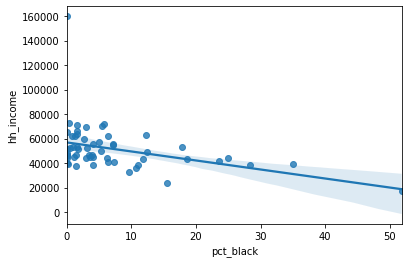

In [531]:
sns.regplot(x=buncombe.pct_black,y=buncombe.hh_income)
plt.show()

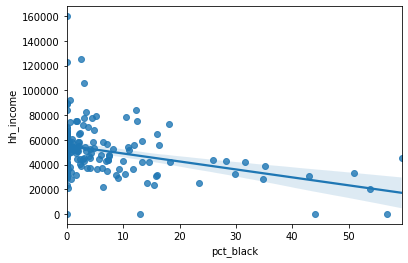

In [532]:
sns.regplot(x=buncombebg.pct_black,y=buncombebg.hh_income)
plt.show()

In [533]:
buncombe.corr()['pct_black']

pop                            -0.185664
white                          -0.347899
black                           0.826531
hh_income                      -0.384315
rent_burden                    -0.176293
pct_black                       1.000000
pct_white                      -0.949012
pct_overall_black_population    0.826576
hcv_section_8_total_count       0.733270
Name: pct_black, dtype: float64

In [534]:
buncombebg.corr()['pct_black']

pop                            -0.095605
white                          -0.308603
black                           0.851981
hh_income                      -0.346321
rent_burden                     0.105181
pct_black                       1.000000
pct_white                      -0.933872
pct_overall_black_population    0.851973
Name: pct_black, dtype: float64